In [18]:
using ITensors, ITensorMPS, Plots, LaTeXStrings
using ProgressMeter,Graphs, LinearAlgebra
push!(LOAD_PATH, ".")
using BP

In [19]:
doubled_gates = Dict(
    "XL" => [0 1 0 0; 1 0 0 0; 0 0 0 -1im; 0 0 1im 0],
    "XR" => [0 1 0 0; 1 0 0 0; 0 0 0 1im; 0 0 -1im 0],
    "XC" => [0 0 0 0; 0 0 0 0; 0 0 0 -2im; 0 0 2im 0],
    "YL" => [0 0 1 0; 0 0 0 1im; 1 0 0 0; 0 -1im 0 0],
    "YR" => [0 0 1 0; 0 0 0 -1im; 1 0 0 0; 0 1im 0 0],
    "YC" => [0 0 0 0; 0 0 0 2im; 0 0 0 0; 0 -2im 0 0],
    "ZL" => [0 0 0 1; 0 0 -1im 0; 0 1im 0 0; 1 0 0 0],
    "ZR" => [0 0 0 1; 0 0 1im 0; 0 -1im 0 0; 1 0 0 0],
    "ZC" => [0 0 0 0; 0 0 -2im 0; 0 2im 0 0; 0 0 0 0],
    "IL" => [1 0 0 0; 0 1 0 0; 0 0 1 0; 0 0 0 1],
    "IR" => [1 0 0 0; 0 1 0 0; 0 0 1 0; 0 0 0 1],
    "IC" => [0 0 0 0; 0 0 0 0; 0 0 0 0; 0 0 0 0],
    "MD" => [0 0 0 -2; 0 -1 0 0; 0 0 -1 0; 0 0 0 -2],
    "PD" => [0 0 0 0; 0 -1 0 0; 0 0 -1 0; 0 0 0 -1],
);

function depolarizing_channel(i,j,p)
    tens = ITensor(Float64, i, j)  
    tens[1,1] = 1  
    for kk = 2:4
        tens[kk,kk] = 1 - (4 * p / 3)
    end 
    return tens
end

depolarizing_channel (generic function with 1 method)

## dynamics stuff

In [35]:
function pair_to_index_folded(i, j)
    return (i - 1) * 4 + j
end

function get_itensor_folded(gate,i1_in,i2_in,i1_out,i2_out)
    U_tensor = ITensor(i1_in,i2_in,i1_out,i2_out)
    for i1_out_val in 1:4, i2_out_val in 1:4, i1_in_val in 1:4, i2_in_val in 1:4
        row = pair_to_index_folded(i1_out_val, i2_out_val)
        col = pair_to_index_folded(i1_in_val, i2_in_val)
        U_tensor[i1_out => i1_out_val, i2_out => i2_out_val,
                 i1_in => i1_in_val, i2_in => i2_in_val] = gate[row, col]
    end
    return  U_tensor
end 


function operator_dynamics(N,T,bitstring_initial,bitstring_final;p=0)
    δt = 0.05
    hamilZZ = (kron(doubled_gates["ZL"],doubled_gates["ZL"]) - kron(doubled_gates["ZR"],doubled_gates["ZR"]))
    hamilYY = (kron(doubled_gates["YL"],doubled_gates["YL"]) - kron(doubled_gates["YR"],doubled_gates["YR"]))
    hamilXX = (kron(doubled_gates["XL"],doubled_gates["XL"]) - kron(doubled_gates["XR"],doubled_gates["XR"]))
    gateZZ = exp(-1im*δt*hamilZZ)
    gateXX = exp(-1im*δt*hamilXX)
    gateYY = exp(-1im*δt*hamilYY)
    indmat = [Index(4, "x$(i)t$(j)") for i in 1:N, j in 0:T]
    χ = 4
    tensors = []

    for x = 1 : N 
        tens = ITensor(indmat[x,1])
        tens[indmat[x,1] => bitstring_initial[x] + 1] = 1 ## set initial pauli string conditions
        push!(tensors,tens)
    end 

    for t = 1 : T 
        if t % 4 == 0
            for x = 1 : 2 : N 
                gate = gateZZ #rand([gateXX,gateYY,gateZZ])
                tens = get_itensor_folded(gate,indmat[x,t],indmat[x+1,t],indmat[x,t+1],indmat[x+1,t+1])
                push!(tensors,tens)
            end 
        elseif t % 4 == 1
            for x = 1 : N 
                tens = depolarizing_channel(indmat[x,t],indmat[x,t+1],p)
                push!(tensors,tens)
            end 
        elseif t % 4 == 2
            for x = 2 : 2 : N-1
                gate = gateZZ #rand([gateXX,gateYY,gateZZ])
                tens = get_itensor_folded(gate,indmat[x,t],indmat[x+1,t],indmat[x,t+1],indmat[x+1,t+1])
                push!(tensors,tens)
            end 
            ten1 = delta(indmat[1,t],indmat[1,t+1])
            ten2 = delta(indmat[N,t],indmat[N,t+1])
            push!(tensors,ten1,ten2)
        elseif t % 4 == 3
            for x = 1 : N 
                tens = depolarizing_channel(indmat[x,t],indmat[x,t+1],p)
                push!(tensors,tens)
            end 
        end 
    end 

    for x = 1 : N 
        tens = ITensor(indmat[x,end])
        tens[indmat[x,end] => bitstring_final[x] + 1] = 1 
        push!(tensors,tens)
    end 
    return tensors 
end 


operator_dynamics (generic function with 1 method)

## Compute $\langle S_x(0) S_x(t) \rangle$ at $\beta = 0$

No tricks in the passing, does not converge.

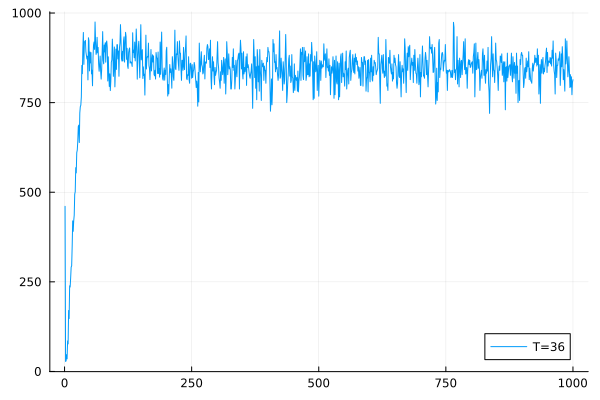

In [36]:
N = 12
T = 36 
initial = zeros(Int32, N)
initial[Int(N/2)] = 1
final = zeros(Int32, N)
final[Int(N/2)] = 1
tensors = operator_dynamics(N,T,initial,final;p=0.0)
adj_mat, edges, links = BP.get_adj_mat(tensors);
messages = BP.get_messages(tensors,edges,links) 
messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=1.,η=0.0,diagnose=true);

plot(arr,label="T=$(T)")

Anneal and add some noise. Converges.

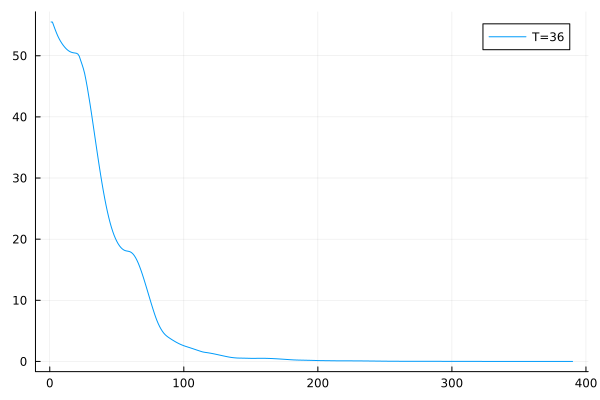

In [37]:
N = 12
T = 36 
initial = zeros(Int32, N)
initial[Int(N/2)] = 1
final = zeros(Int32, N)
final[Int(N/2)] = 1
tensors = operator_dynamics(N,T,initial,final;p=0.0)
adj_mat, edges, links = BP.get_adj_mat(tensors);
messages = BP.get_messages(tensors,edges,links) 
messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=.5,η=0.001,diagnose=true);

plot(arr,label="T=$(T)")

In [16]:
ans = []
ts = 1:4:48
N = 16
initial = zeros(Int32, N)
initial[Int(N/2)] = 1
final = zeros(Int32, N)
final[Int(N/2)] = 1

@showprogress for T in ts
    tensors = operator_dynamics(N,T,initial,final;p=0.01)
    adj_mat, edges, links = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors,edges,links) 
    messages = BP.message_passing(tensors,messages,edges,links,adj_mat;α=1.,η=0.01,diagnose=false)
    push!(ans,BP.mean_free_partition_fn(Set(1:length(tensors)),tensors,messages,edges,links,adj_mat))
end 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


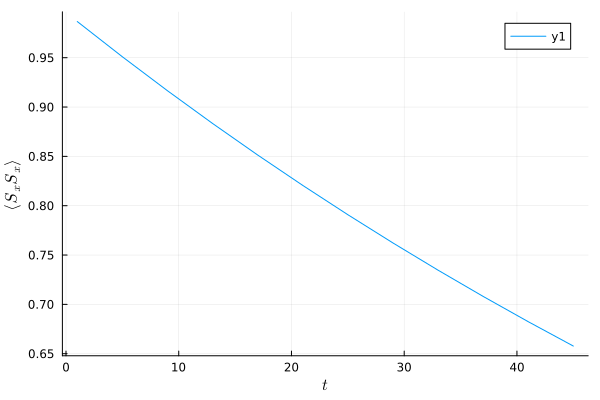

In [17]:
plot(ts,abs.(ans),xlabel=L"t",ylabel=L"\langle S_x S_x \rangle")